# Real Vs Fake Job Posting

#### Importing necessary libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import sqlite3
from sqlite3 import Error
import csv
import matplotlib.pyplot as plt
import seaborn as sns


import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

#### Defining functions for Sqlite

In [2]:
def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn


def create_table(conn, create_table_sql, drop_table_name=None):
    
    if drop_table_name: # You can optionally pass drop_table_name to drop the table. 
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Error as e:
            print(e)
    
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows

In [3]:
filename = "fake_job_postings.csv"

In [4]:
with open(filename) as file:
    raw_data = list(csv.reader(file, delimiter=","))
raw_data = raw_data[1:]
raw_data1 = [tuple(i) for i in raw_data]

In [5]:
db_file = 'raw_data.db'
import os
if os.path.exists(db_file):
    os.remove(db_file)
conn = create_connection(db_file)

create_table_sql1 = """
    CREATE TABLE IF NOT EXISTS [raw_data] (
        [job_id] integer not null primary key,
        [title] text,
        [location] text,
        [department] text,
        [salary_range] text,
        [company_profile] text,
        [description] text,
        [requirements] text,
        [benefits] text,
        [telecommuting] integer,
        [has_company_logo] integer,
        [has_questions] integer,
        [employment_type] text,
        [required_experience] text,
        [required_education] text,
        [industry] text,
        [function] text,
        [fraudulent] integer
    );
    """

def insert_raw_data(conn, values):
    sql = ''' INSERT INTO raw_data(job_id,title,location,
                department,salary_range,company_profile,description,
                requirements,benefits,telecommuting,has_company_logo,
                has_questions,employment_type,required_experience,
                required_education,industry,function,fraudulent) 
                VALUES(?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?) '''
    cur = conn.cursor()
    cur.execute(sql, values)
    return cur.lastrowid

with conn:
        create_table(conn, create_table_sql1)
        for values in raw_data1:
            insert_raw_data(conn,values)

In [6]:
db_file_norm = 'normalized_data.db'
if os.path.exists(db_file_norm):
    os.remove(db_file_norm)
conn1 = create_connection(db_file_norm)

In [7]:
sql_statement = 'SELECT distinct company_profile, has_company_logo,count(job_id) from raw_data group by company_profile,has_company_logo order by company_profile'
df = pd.read_sql_query(sql_statement, conn)
display(df)

,company_profile,has_company_logo,count(job_id)
0,,0,2622
1,,1,686
2,Value Added Team of Creative ProfessionalsNet...,1,1
3,"""Only stupid questions create wealth"" - Gary ...",1,1
4,"""Our mission to our clients is to preserve the...",1,64
...,...,...,...
1706,Το #URL_bb79581a561837ad604b8fc4ab629753b36407...,1,4
1707,"УУРРАА - технологическая компания, работающая ...",1,9
1708,“News360 is Changing the Content Delivery Game...,1,1
1709,"“No surveys, social data can answer your quest...",1,1


In [8]:
l1 = df.iloc[2:,0].values
l1.shape

(1709,)

In [9]:
np.unique(l1).shape

(1709,)

In [10]:
sql_statement = 'SELECT distinct department, count(job_id) from raw_data group by department'
df = pd.read_sql_query(sql_statement, conn)
df.head(50)

,department,count(job_id)
0,,11547
1,,6
2,\tCorporate Shared Services,1
3,Lower Level Management,1
4,Marketing,1
5,Moni Technologies,1
6,R&D,1
7,(Consultant),1
8,.NET,1
9,.net Development,1


In [11]:
# with conn:
#     sql_statement = 'SELECT distinct title from raw_data'
#     value_profile = execute_sql_statement(sql_statement, conn)

sql_statement = """
    SELECT count(*) FROM raw_data WHERE (job_id+title+location+department+salary_range+company_profile+description+requirements+benefits+telecommuting+has_company_logo+has_questions+employment_type+required_experience+required_education+industry+function+fraudulent) = ' '
    """

df = pd.read_sql_query(sql_statement, conn)
df

,count(*)
0,0


- title - title
- department - distinct department
- salary - id, distinct salary(min max)
- description - description
- requirements - id, req
- benefits - id,benefits

- telecommuting
- has_company_logo
- has_questions
- employment_type - 
- required_experience
- required_education
- industry


- function
- fraudulent
------ job_title_loc: job_id, title, locid, titleid, salaryid
- company table: companyid, company_profile, has_company_logo
- location table: locid,location - seggregated
- jobid - companyid,  ###company_profile


- desc and company change
- posting: jobid,companyid, titleid,locID,deptID,salaryID, telecommuting,has_questions, employmentid, req_exp_id,req_edu_id,industryid,functionID, requirementID, benefitID,fraudulent



- DescriptionID, reqID, BenefitID, telecommuting, has_questions,employment_typeID,required_experience,required_education,industry,function
- 

In [12]:
with conn:
    sql_statement = 'SELECT distinct job_id,title,location,department,salary_range,company_profile,description,requirements,benefits from raw_data'
    raw_data = execute_sql_statement(sql_statement, conn)

In [13]:
job_idx = []
titles = []
depts = []
salaries = []
requirements = []
benefits = []

for data in raw_data:
    job_id = data[0]
    job_idx.append(job_id)
    
    title = data[1]
    titles.append((title,))
    
    dept = data[3]
    depts.append((dept,))
    
    salary_range = data[4]
    if '-' in salary_range:
        min_salary = salary_range.split('-')[0].split(' ')[0]
        max_salary = salary_range.split('-')[1].split(' ')[-1]
    else:
        min_salary = ''
        max_salary = ''
    salaries.append((salary_range, min_salary, max_salary))
    
    requirement = data[7]
    requirements.append((requirement,))
    
    benefit = data[8]
    benefits.append((benefit,))

titles = tuple(set(titles))
depts = tuple(set(depts))
salaries = tuple(set(salaries))
requirements = tuple(set(requirements))
benefits = tuple(set(benefits))

In [14]:
titles

(('Project Manager ',),
 ('Customer Support Intern - German and other languages',),
 ('Front End Developer | Client-Side Coder',),
 ('Receptionist - Entry Level',),
 ('Publisher Network Coordinator',),
 ('Java/J2EE Developer (Weblogic, Web Services) fluent in French ',),
 ('ASP.NET (C#) Developer',),
 (' Agile Business Analyst',),
 ('SAP BI ANALYST TRAINEE',),
 ('UST Testing Technician',),
 ('Client Services Administrator - Oakland, CA',),
 ('Auditor',),
 ('Meeting Point Manager - International Tourism Company in Manhattan',),
 ('Fragrance and Beauty Sales/Promotional Staff needed',),
 ('PHP DEVELOPER WITH WORDPRESS',),
 ('M50 3XP Apprentice Recruitment Consultant government funding for 16-18 year olds only',),
 ('Process Safety Engineer',),
 ('Software Engineer - C#.Net HTML CSS Java XML PHP C#- NV',),
 ('Regional Inside Sales Representative',),
 ('Electrical Controls Engineer',),
 ('Research Engineer Data Science',),
 ('Direct Support Professional- Part-time',),
 ('Senior DevOps Engi

In [15]:
def insert_titles(titles,conn):
    table_sql = """
                    CREATE TABLE [Titles] (
                        [TitleID] Integer not null primary key,
                        [Title] Text
                    )
                    """
    
    cur = conn.cursor()
    insert_sql = """
                    INSERT INTO Titles (Title)
                    Values (?)
                    """
    
    with conn:
        create_table(conn, table_sql, "Titles")
        cur.executemany(insert_sql, titles)
    return cur.lastrowid
    
def insert_departments(departments,conn):
    table_sql = """
                    CREATE TABLE [Departments] (
                        [DepartmentID] Integer not null primary key,
                        [Department] Text
                    )
                    """
    
    cur = conn.cursor()
    insert_sql = """
                    INSERT INTO Departments (Department)
                    Values (?)
                    """
    with conn:
        create_table(conn, table_sql, "Departments")
        cur.executemany(insert_sql, departments)
    return cur.lastrowid
    
def insert_salaries(salaries,conn):
    table_sql = """
                    CREATE TABLE [Salaries] (
                        [SalaryID] Integer not null primary key,
                        [Salary_Range] Text,
                        [Min_Salary] REAL,
                        [Max_Salary] REAL
                    );
                    """
    
    cur = conn.cursor()
    insert_sql = """
                    INSERT INTO Salaries (Salary_Range, Min_Salary, Max_Salary)
                    Values (?,?,?)
                    """
    with conn:
        create_table(conn, table_sql, "Salaries")
        cur.executemany(insert_sql, salaries)
    return cur.lastrowid
    
def insert_requirements(requirements,conn):
    table_sql = """
                    CREATE TABLE [Requirements] (
                        [RequirementID] Integer not null primary key,
                        [Requirement] Text
                    )
                    """
    
    cur = conn.cursor()
    insert_sql = """
                    INSERT INTO Requirements (Requirement)
                    Values (?)
                    """
    with conn:
        create_table(conn, table_sql, "Requirements")
        cur.executemany(insert_sql, requirements)
    return cur.lastrowid
    
def insert_benefits(benefits,conn):
    table_sql = """
                    CREATE TABLE [Benefits] (
                        [BenefitID] Integer not null primary key,
                        [Benefit] Text
                    )
                    """
    
    cur = conn.cursor()
    insert_sql = """
                    INSERT INTO Benefits (Benefit)
                    Values (?)
                    """
    with conn:
        create_table(conn, table_sql, "Benefits")
        cur.executemany(insert_sql, benefits)
    return cur.lastrowid
    
insert_titles(titles,conn1)
insert_departments(depts,conn1)
insert_salaries(salaries,conn1)
insert_requirements(requirements,conn1)
insert_benefits(benefits,conn1)

In [16]:
with conn:
    sql_statement = 'SELECT distinct telecommuting from raw_data'
    value_telecommuting = execute_sql_statement(sql_statement, conn)
#     insert_tuple = []
#     for row in value_telecommuting:
#         if row[0] == 1:
#             insert_tuple.append((True,))
#         else :
#             insert_tuple.append((False,)) 
    
    
create_table_telecommuting = """
    CREATE TABLE IF NOT EXISTS [Telecommuting] (
        [telecommutingId] integer not null primary key,
        [isTelecommuting] integer not null
    );
    """

def insert_telecommuting(conn, values):
    sql = ''' INSERT INTO Telecommuting(isTelecommuting) 
                VALUES(?) '''
    cur = conn.cursor()
    cur.executemany(sql, values)
    return cur.lastrowid

   

with conn1:
    create_table(conn1, create_table_telecommuting,'Telecommuting')
    insert_telecommuting(conn1,value_telecommuting)
#     sql_statement = 'SELECT * from Telecommuting'
#     telecommuting = execute_sql_statement(sql_statement, conn1)

In [17]:
value_telecommuting

[(0,), (1,)]

In [18]:
with conn:
    sql_statement = 'SELECT distinct has_company_logo from raw_data'
    value_companylogo = execute_sql_statement(sql_statement, conn)
#     insert_tuple = []
#     for row in value_telecommuting:
#         if row[0] == 1:
#             insert_tuple.append((True,))
#         else :
#             insert_tuple.append((False,)) 
    
    
create_table_sql2 = """
    CREATE TABLE IF NOT EXISTS [Companylogo] (
        [LogoId] integer not null primary key,
        [HasLogo] integer not null
    );
    """

def insert_companylogo(conn, values):
    sql = ''' INSERT INTO Companylogo(HasLogo) 
                VALUES(?) '''
    cur = conn.cursor()
    cur.executemany(sql, values)
    return cur.lastrowid

   

with conn1:
    create_table(conn1, create_table_sql2,'Companylogo')
    insert_companylogo(conn1,value_companylogo)
#     sql_statement = 'SELECT * from Companylogo'
#     logo = execute_sql_statement(sql_statement, conn1)

In [19]:
with conn:
    sql_statement = 'SELECT distinct has_questions from raw_data'
    value_questions = execute_sql_statement(sql_statement, conn)
#     insert_tuple = []
#     for row in value_telecommuting:
#         if row[0] == 1:
#             insert_tuple.append((True,))
#         else :
#             insert_tuple.append((False,)) 
    
    
create_table_sql2 = """
    CREATE TABLE IF NOT EXISTS [HasQuestions] (
        [QuestionId] integer not null primary key,
        [HasQuestion] integer not null
    );
    """

def insert_questions(conn, values):
    sql = ''' INSERT INTO HasQuestions(HasQuestion) 
                VALUES(?) '''
    cur = conn.cursor()
    cur.executemany(sql, values)
    return cur.lastrowid

   

with conn1:
    create_table(conn1, create_table_sql2,'HasQuestions')
    insert_questions(conn1,value_questions)
#     sql_statement = 'SELECT * from HasQuestions'
#     question = execute_sql_statement(sql_statement, conn1)

In [20]:
with conn:
    sql_statement = 'SELECT distinct employment_type from raw_data'
    value_employment_type = execute_sql_statement(sql_statement, conn)

create_table_sql2 = """
    CREATE TABLE IF NOT EXISTS [EmploymentTypes] (
        [EmploymentTypeId] integer not null primary key,
        [EmploymentType] text
    );
    """

def insert_eType(conn, values):
    sql = ''' INSERT INTO EmploymentTypes(EmploymentType) 
                VALUES(?) '''
    cur = conn.cursor()
    cur.executemany(sql, values)
    return cur.lastrowid

   

with conn1:
    create_table(conn1, create_table_sql2,'EmploymentTypes')
    insert_eType(conn1,value_employment_type)
#     sql_statement = 'SELECT * from EmploymentTypes'
#     employment_type = execute_sql_statement(sql_statement, conn1)

In [21]:
with conn:
    sql_statement = 'SELECT distinct required_experience from raw_data'
    value_required_experience = execute_sql_statement(sql_statement, conn)

    
create_table_sql2 = """
    CREATE TABLE IF NOT EXISTS [RequiredExperiences] (
        [RequiredExperienceId] integer not null primary key,
        [RequiredExperience] Text
    );
    """

def insert_req_experience(conn, values):
    sql = ''' INSERT INTO RequiredExperiences(RequiredExperience) 
                VALUES(?) '''
    cur = conn.cursor()
    cur.executemany(sql, values)
    return cur.lastrowid

   

with conn1:
    create_table(conn1, create_table_sql2,'RequiredExperience')
    insert_req_experience(conn1,value_required_experience)
#     sql_statement = 'SELECT * from RequiredExperiences'
#     experience_type = execute_sql_statement(sql_statement, conn1)

In [22]:
with conn:
    sql_statement = 'SELECT distinct required_education from raw_data'
    value_required_education = execute_sql_statement(sql_statement, conn) 
    
create_table_sql2 = """
    CREATE TABLE IF NOT EXISTS [RequiredEducation] (
        [RequiredEducationId] integer not null primary key,
        [Education] Text
    );
    """

def insert_req_education(conn, values):
    sql = ''' INSERT INTO RequiredEducation(Education) 
                VALUES(?) '''
    cur = conn.cursor()
    cur.executemany(sql, values)
    return cur.lastrowid

   

with conn1:
    create_table(conn1, create_table_sql2,'Education')
    insert_req_education(conn1,value_required_education)
#     sql_statement = 'SELECT * from RequiredEducation'
#     required_education = execute_sql_statement(sql_statement, conn1)

In [23]:
with conn:
    sql_statement = 'SELECT distinct industry from raw_data'
    value_industry = execute_sql_statement(sql_statement, conn) 
    
create_table_sql2 = """
    CREATE TABLE IF NOT EXISTS [Industry] (
        [IndustryId] integer not null primary key,
        [IndustryName] Text
    );
    """

def insert_Industry(conn, values):
    sql = ''' INSERT INTO Industry(IndustryName) 
                VALUES(?) '''
    cur = conn.cursor()
    cur.executemany(sql, values)
    return cur.lastrowid

   

with conn1:
    create_table(conn1, create_table_sql2,'Industry')
    insert_Industry(conn1,value_industry)
#     sql_statement = 'SELECT * from Industry'
#     industry = execute_sql_statement(sql_statement, conn1)

In [24]:
with conn: 
    sql_statement = "SELECT distinct function from raw_data"
    value_profile = execute_sql_statement(sql_statement, conn)

create_table_sql2 = """
    CREATE TABLE IF NOT EXISTS [function] (
        [functionID] integer not null primary key,
        [function] text not null
    );
    """

def insert_profile(conn, values):
    sql = ''' INSERT INTO function(function) 
                VALUES(?) '''
    cur = conn.cursor()
    cur.execute(sql, values)
    return cur.lastrowid

   

with conn1:
    create_table(conn1, create_table_sql2,'function')
    for values in value_profile:
        insert_profile(conn1,values)

In [25]:
with conn: 
    sql_statement = "SELECT distinct fraudulent from raw_data where fraudulent != ''"
    value_fraudulent = execute_sql_statement(sql_statement, conn)

create_table_sql2 = """
    CREATE TABLE IF NOT EXISTS [fraudulent] (
        [fraudulent] integer not null primary key
    );
    """

def insert_profile(conn, values):
    sql = ''' INSERT INTO fraudulent(fraudulent) 
                VALUES(?) '''
    cur = conn.cursor()
    cur.execute(sql, values)
    return cur.lastrowid

   

with conn1:
    create_table(conn1, create_table_sql2,'fraudulent')
    for values in value_fraudulent:
        insert_profile(conn1,values)

In [26]:
# with conn1: 
#     sql_statement = "DROP table Title"
#     execute_sql_statement(sql_statement, conn1)

In [27]:
# description - description

with conn: 
    sql_statement = "SELECT distinct description from raw_data"
    value_profile = execute_sql_statement(sql_statement, conn)

create_table_sql2 = """
    CREATE TABLE IF NOT EXISTS [Description] (
        [DescriptionID] integer not null primary key,
        [Description] text not null
    );
    """

def insert_profile(conn, values):
    sql = ''' INSERT INTO Description(Description) 
                VALUES(?) '''
    cur = conn.cursor()
    cur.executemany(sql, values)
    return cur.lastrowid

   

with conn1:
    create_table(conn1, create_table_sql2,'Description')
    insert_profile(conn1,value_profile)

In [28]:
# Company

with conn: 
    sql_statement = "SELECT distinct company_profile,description,has_company_logo from raw_data"
    value_profile = execute_sql_statement(sql_statement, conn)
with conn1: 
    sql_statement = "SELECT DescriptionID,Description from Description"
    value_comp = execute_sql_statement(sql_statement, conn1)
comp_dict = {}
desc_list = []

for row in value_comp:
    key,text = row
    comp_dict[text] = key

for i in value_profile:
    for k1,v1 in comp_dict.items():
        if i[1] == k1:
            desc_list.append((i[0],i[2],v1))

create_table_sql2 = """
    CREATE TABLE IF NOT EXISTS [Company] (
        [CompanyID] integer not null primary key,
        [company_profile] text,
        [has_company_logo] integer,
        [DescriptionID] integer not null,
        Foreign key(DescriptionID) references Description(DescriptionID)
    );
    """

def insert_profile(conn, values):
    sql = ''' INSERT INTO Company(company_profile,has_company_logo,DescriptionID) 
                VALUES(?,?,?) '''
    cur = conn.cursor()
    cur.executemany(sql, values)
    return cur.lastrowid

   

with conn1:
    create_table(conn1, create_table_sql2,'Company')
    insert_profile(conn1,desc_list)

In [29]:
# location table: locid,location - seggregated

with conn: 
    sql_statement = "SELECT distinct location from raw_data"
    value_profile = execute_sql_statement(sql_statement, conn)
    
list_country = []
list_state = []
list_city = []
list_loc1 = []
for i in value_profile:
    for j in i:
        list_loc1.append(j)
        if j.split(',')[0].strip() != '':
            list_country.append(j.split(',')[0].strip())
        else:
            list_country.append('')
        if len(j.split(','))!=1:
            if j.split(',')[1].strip() != '':
                list_state.append(j.split(',')[1].strip())
            else:
                list_state.append('')
        else:
            list_state.append('')
        if len(j.split(','))!=1:
            if j.split(',')[2].strip() != '':
                list_city.append(j.split(',')[2].strip())
            else:
                list_city.append('')
        else:
            list_city.append('')

list_loc = [(i,j,k,l) for i,j,k,l in zip(list_loc1,list_country,list_state,list_city)]

create_table_sql2 = """
    CREATE TABLE IF NOT EXISTS [Location] (
        [LocationID] integer not null primary key,
        [Location] text not null,
        [Country] text not null,
        [State] text not null,
        [City] text not null
    );
    """

def insert_profile(conn, values):
    sql = ''' INSERT INTO Location(Location,Country,State,City) 
                VALUES(?,?,?,?) '''
    cur = conn.cursor()
    cur.executemany(sql, values)
    return cur.lastrowid

   

with conn1:
    create_table(conn1, create_table_sql2,'Location')
    insert_profile(conn1,list_loc)

In [30]:
# posting: jobid,companyid, titleid,locID,salaryID, telecommuting,has_questions, 
# employmentid, req_exp_id,req_edu_id,industryid,functionID, requirementID, benefitID,fraudulent

# job_id,title,location,
#                 department,salary_range,company_profile,description,
#                 requirements,benefits,telecommuting,has_company_logo,
#                 has_questions,employment_type,required_experience,
#                 required_education,industry,function,fraudulent


with conn: 
    sql_statement = """SELECT distinct job_id,title,location,department,salary_range,
    company_profile,requirements,benefits,telecommuting, has_questions,
    employment_type,required_experience,required_education,industry,
    function,fraudulent from raw_data"""
    raw_data_post = execute_sql_statement(sql_statement, conn)
with conn1: 
    sql_statement1 = "SELECT TitleID,Title from Titles"
    value_title = execute_sql_statement(sql_statement1, conn1)
    sql_statement2 = "SELECT LocationID,Location from Location"
    value_loc = execute_sql_statement(sql_statement2, conn1)
    sql_statement3 = "SELECT DepartmentID,Department from Departments"
    value_dept = execute_sql_statement(sql_statement3, conn1)
    sql_statement4 = "SELECT SalaryID,Salary_Range from Salaries"
    value_sal = execute_sql_statement(sql_statement4, conn1)
    sql_statement5 = "SELECT CompanyID,company_profile from Company"
    value_comp = execute_sql_statement(sql_statement5, conn1)
    sql_statement6 = "SELECT RequirementID,Requirement from Requirements"
    value_req = execute_sql_statement(sql_statement6, conn1)
    sql_statement7 = "SELECT BenefitID,Benefit from Benefits"
    value_benefits = execute_sql_statement(sql_statement7, conn1)
    sql_statement8 = "SELECT EmploymentTypeId,EmploymentType from EmploymentTypes"
    value_emp = execute_sql_statement(sql_statement8, conn1)
    sql_statement9 = "SELECT RequiredExperienceId,RequiredExperience from RequiredExperiences"
    value_req_exp = execute_sql_statement(sql_statement9, conn1)
    sql_statement10 = "SELECT RequiredEducationId,Education from RequiredEducation"
    value_req_edu = execute_sql_statement(sql_statement10, conn1)
    sql_statement11 = "SELECT IndustryID,IndustryName from Industry"
    value_ind = execute_sql_statement(sql_statement11, conn1)
    sql_statement12 = "SELECT functionID,function from function"
    value_func = execute_sql_statement(sql_statement12, conn1)



def create_list_posting(raw_data_post,value,n):
    value_dict = {}
    post_list = []
    for row in value:
        key,text = row
        value_dict[text] = key

    for i in raw_data_post:
        for k1,v1 in value_dict.items():
            if i[n] == k1:
                post_list.append((i[0],v1))
    return post_list

title_list = create_list_posting(raw_data_post,value_title,1)
loc_list = create_list_posting(raw_data_post,value_loc,2)
dept_list = create_list_posting(raw_data_post,value_dept,3)
sal_list = create_list_posting(raw_data_post,value_sal,4)
comp_list = create_list_posting(raw_data_post,value_comp,5)
req_list = create_list_posting(raw_data_post,value_req,6)
benefits_list = create_list_posting(raw_data_post,value_benefits,7)
emp_list = create_list_posting(raw_data_post,value_emp,10)
exp_list = create_list_posting(raw_data_post,value_req_exp,11)
edu_list = create_list_posting(raw_data_post,value_req_edu,12)
ind_list = create_list_posting(raw_data_post,value_ind,13)
func_list = create_list_posting(raw_data_post,value_func,14)



In [31]:
dict_post = {}

def append_list(dict_post,list_x):
    for record in list_x:
        dict_post[record[0]] = dict_post.get(record[0],[])
        dict_post[record[0]].append(record[1])
    return dict_post

for i in (title_list,loc_list,dept_list,sal_list,comp_list,req_list,benefits_list,emp_list,exp_list,edu_list,ind_list,func_list):
    dict_post = append_list(dict_post,i)


In [32]:
post_list = []
for k,v in dict_post.items():
    for i in raw_data_post:
        if i[0] == k:
            post_list.append((i[0],v[0],v[1],v[2],v[3],v[4],v[5],v[6],i[8],i[9],v[7],v[8],v[9],v[10],v[11],i[15]))


In [33]:
create_table_sql2 = """
    CREATE TABLE IF NOT EXISTS [Posting] (
        [job_id] integer not null primary key,
        [TitleID] integer,
        [LocationID] integer,
        [DepartmentID] integer,
        [SalaryID] integer,
        [CompanyID] integer,
        [RequirementID] integer,
        [BenefitID] integer,
        [telecommuting] integer,
        [has_questions] integer,
        [EmploymentTypeId] integer,
        [RequiredExperienceId] integer,
        [RequiredEducationId] integer,
        [IndustryId] integer,
        [functionID] integer,
        [fraudulent] integer,
        Foreign key(TitleID) references Titles(TitleID),
        Foreign key(LocationID) references Location(LocationID),
        Foreign key(DepartmentID) references Departments(DepartmentID),
        Foreign key(SalaryID) references Salaries(SalaryID),
        Foreign key(CompanyID) references Company(CompanyID),
        Foreign key(RequirementID) references Requirements(RequirementID),
        Foreign key(BenefitID) references Benefits(BenefitID),
        Foreign key(EmploymentTypeId) references EmploymentTypes(EmploymentTypeId),
        Foreign key(RequiredExperienceId) references RequiredExperiences(RequiredExperienceId),
        Foreign key(RequiredEducationId) references RequiredEducation(RequiredEducationId),
        Foreign key(IndustryId) references Industry(IndustryId),
        Foreign key(functionID) references function(functionID)
    );
    """

def insert_posting(conn, values):
    sql = ''' INSERT INTO Posting(job_id,TitleID,LocationID,DepartmentID,
    SalaryID,CompanyID,RequirementID,BenefitID,telecommuting,has_questions,EmploymentTypeId,
    RequiredExperienceId,RequiredEducationId,IndustryId,functionID,fraudulent) 
                VALUES(?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?) '''
    cur = conn.cursor()
    cur.executemany(sql, values)
    return cur.lastrowid



In [34]:

with conn1:
    create_table(conn1, create_table_sql2,'Posting')
    insert_posting(conn1,post_list)

In [35]:
sql_show_tables = """SELECT name FROM sqlite_master  
WHERE type='table'"""
res = execute_sql_statement(sql_show_tables,conn1)
print(res)

[('Titles',), ('Departments',), ('Salaries',), ('Requirements',), ('Benefits',), ('Telecommuting',), ('Companylogo',), ('HasQuestions',), ('EmploymentTypes',), ('RequiredExperiences',), ('RequiredEducation',), ('Industry',), ('function',), ('fraudulent',), ('Description',), ('Company',), ('Location',), ('Posting',)]


# Exploratory Data Analysis

In [36]:
sql_statement_eda = """
select
job_id,
fraudulent from posting
"""
df = pd.read_sql_query(sql_statement_eda,conn1)
fraudulent_dist = df.fraudulent.value_counts()
print(fraudulent_dist)

0    17014
1      866
Name: fraudulent, dtype: int64


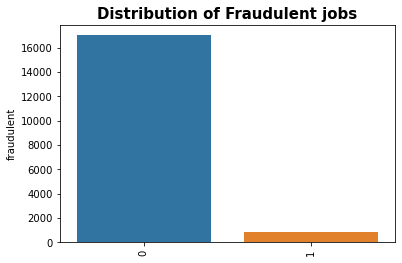

In [37]:
chart = sns.barplot(x=fraudulent_dist.index, y=fraudulent_dist)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.title('Distribution of Fraudulent jobs',size=15, weight='bold')
plt.show()

In [38]:
sql_statement_eda_loc = """
select
CASE l.Country
        WHEN '' THEN 'Unknown'
        ELSE l.Country
    END Country,
CASE l.State
        WHEN '' THEN 'Unknown'
        ELSE l.State
    END State,
CASE l.City
        WHEN '' THEN 'Unknown'
        ELSE l.City
    END City,
p.job_id
from posting p inner join location l
on l.LocationID = p.LocationID
"""
df = pd.read_sql_query(sql_statement_eda_loc,conn1)


In [39]:
Country_dist = df.Country.value_counts()
State_dist = df.State.value_counts()
City_dist = df.City.value_counts()
print(Country_dist.head(10))

US         10656
GB          2384
GR           940
CA           457
DE           383
Unknown      346
NZ           333
IN           276
AU           214
PH           132
Name: Country, dtype: int64


In [40]:
print(State_dist.head(10))

Unknown    2580
CA         2051
NY         1259
LND         992
TX          975
I           688
IL          424
FL          415
OH          372
VA          332
Name: State, dtype: int64


In [41]:
print(City_dist.head(10))

Unknown          2068
London           1089
New York          685
Athens            548
San Francisco     486
Houston           272
Berlin            263
Washington        259
Chicago           259
Auckland          234
Name: City, dtype: int64


In [42]:
sql_statement_eda_loc1 = """
with sql1 as
(select
CASE l.Country
        WHEN '' THEN 'Unknown'
        ELSE l.Country
    END Country,
count(p.fraudulent) as fraudulent
from posting p inner join location l
on l.LocationID = p.LocationID
where p.fraudulent = 0
group by
Country
order by fraudulent desc),
sql2 as
(select
CASE l.Country
        WHEN '' THEN 'Unknown'
        ELSE l.Country
    END Country,
count(p.fraudulent) as fraudulent
from posting p inner join location l
on l.LocationID = p.LocationID
where p.fraudulent = 1
group by
Country
order by fraudulent desc)
select s1.Country,
s1.fraudulent as fraudulent_0,
s2.fraudulent as fraudulent_1
from
sql1 s1 inner join sql2 s2
on s1.Country = s2.Country

"""
df_count_1 = pd.read_sql_query(sql_statement_eda_loc1,conn1)

In [43]:
sql_statement_eda_loc1 = """
select
CASE l.Country
        WHEN '' THEN 'Unknown'
        ELSE l.Country
    END Country,
count(p.job_id) as jobs
from posting p inner join location l
on l.LocationID = p.LocationID
where p.fraudulent = 1
group by
CASE l.Country
        WHEN '' THEN 'Unknown'
        ELSE l.Country
    END
order by jobs desc
limit 20
"""
df_count_1 = pd.read_sql_query(sql_statement_eda_loc1,conn1)

In [44]:
df_count_1

,Country,jobs
0,US,730
1,AU,40
2,GB,23
3,Unknown,19
4,MY,12
5,CA,12
6,QA,6
7,BH,5
8,IN,4
9,PL,3


In [45]:
# plt.figure(figsize=(8,6))
# chart = sns.barplot(data=df_count_1, x=df_count_1.Country, y=df_count_1.jobs, hue=df_count_1.fraudulent)
# chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
# plt.title('Distribution of jobs with respect to Country posted on the job',size=15, weight='bold')
# plt.show()

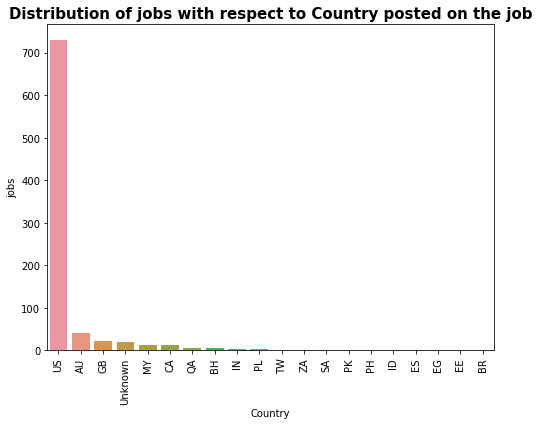

In [46]:
plt.figure(figsize=(8,6))
chart = sns.barplot(data=df_count_1, x=df_count_1.Country, y=df_count_1.jobs)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.title('Distribution of jobs with respect to Country posted on the job',size=15, weight='bold')
plt.show()

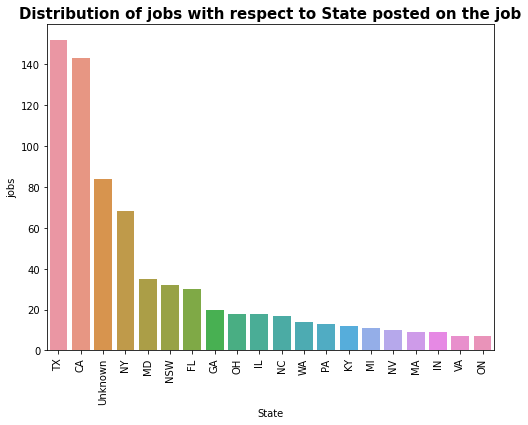

In [47]:
sql_statement_eda_loc1 = """
select
CASE l.State
        WHEN '' THEN 'Unknown'
        ELSE l.State
    END State,
count(p.job_id) as jobs
from posting p inner join location l
on l.LocationID = p.LocationID
where p.fraudulent = 1
group by
State
order by jobs desc
limit 20
"""
df_state_1 = pd.read_sql_query(sql_statement_eda_loc1,conn1)

plt.figure(figsize=(8,6))
chart = sns.barplot(data=df_state_1, x=df_state_1.State, y=df_state_1.jobs)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.title('Distribution of jobs with respect to State posted on the job',size=15, weight='bold')
plt.show()


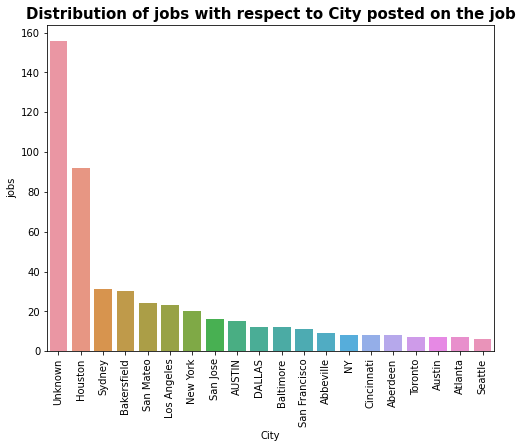

In [48]:
sql_statement_eda_loc1 = """
select
CASE l.City
        WHEN '' THEN 'Unknown'
        ELSE l.City
    END City,
count(p.job_id) as jobs
from posting p inner join location l
on l.LocationID = p.LocationID
where p.fraudulent = 1
group by
City
order by jobs desc
limit 20
"""
df_city_1 = pd.read_sql_query(sql_statement_eda_loc1,conn1)

plt.figure(figsize=(8,6))
chart = sns.barplot(data=df_city_1, x=df_city_1.City, y=df_city_1.jobs)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.title('Distribution of jobs with respect to City posted on the job',size=15, weight='bold')
plt.show()


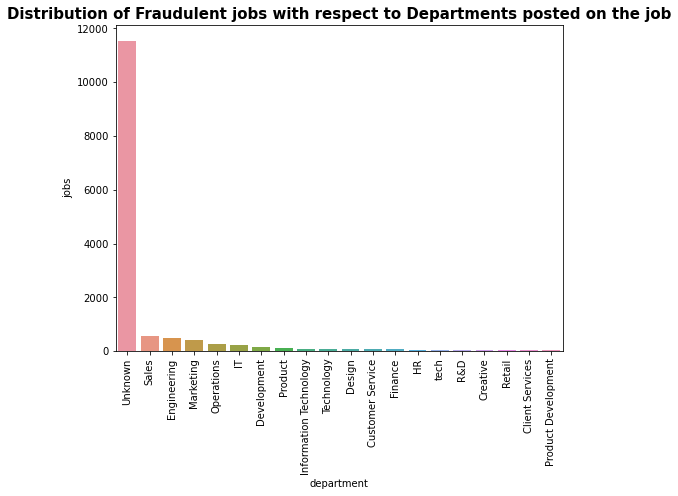

In [49]:
sql_statement_eda_dept = """
select
CASE d.department
        WHEN '' THEN 'Unknown'
        ELSE d.department
    END department,
count(p.job_id) as jobs
from posting p inner join departments d
on d.DepartmentID = p.DepartmentID
group by
CASE d.department
        WHEN '' THEN 'Unknown'
        ELSE d.department
    END
order by jobs desc
limit 20
"""


df_dept = pd.read_sql_query(sql_statement_eda_dept,conn1)
df_dept
plt.figure(figsize=(8,6))
chart = sns.barplot(data=df_dept, x=df_dept.department, y=df_dept.jobs)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.title('Distribution of Fraudulent jobs with respect to Departments posted on the job',size=15, weight='bold')
plt.show()


- Department column have very high null values hence it has to be dropped before creating the model

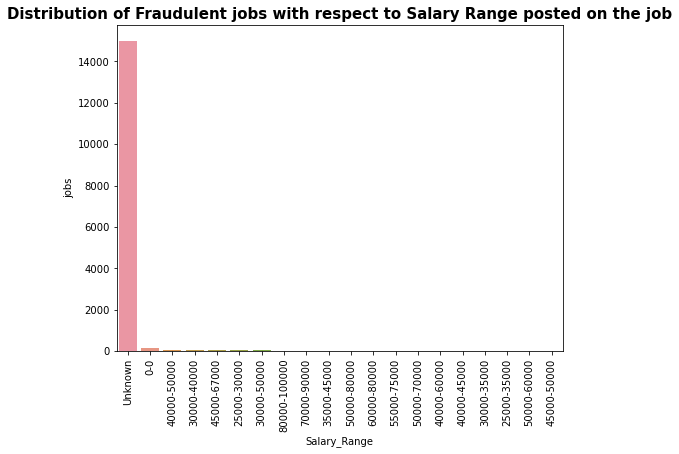

In [54]:
sql_statement_eda_sal = """
select
CASE s.Salary_Range
        WHEN '' THEN 'Unknown'
        ELSE s.Salary_Range
    END Salary_Range,
count(p.job_id) as jobs
from posting p inner join Salaries s
on s.SalaryID = p.SalaryID
group by
CASE s.Salary_Range
        WHEN '' THEN 'Unknown'
        ELSE s.Salary_Range
    END
order by jobs desc
limit 20
"""


df_sal = pd.read_sql_query(sql_statement_eda_sal,conn1)

plt.figure(figsize=(8,6))
chart = sns.barplot(data=df_sal, x=df_sal.Salary_Range, y=df_sal.jobs)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.title('Distribution of Fraudulent jobs with respect to Salary Range posted on the job',size=15, weight='bold')
plt.show()


- Salary Range column have very high null values hence it has to be dropped before creating the model

In [55]:
sql_statement_eda_loc1 = """
select
CASE l.Country
        WHEN '' THEN 'Unknown'
        ELSE l.Country
    END Country,
CASE l.State
        WHEN '' THEN 'Unknown'
        ELSE l.State
    END State,
CASE l.City
        WHEN '' THEN 'Unknown'
        ELSE l.City
    END City,
count(p.fraudulent) as fraudulent
from posting p inner join location l
on l.LocationID = p.LocationID
group by
Country,
State,
City
"""
df = pd.read_sql_query(sql_statement_eda_loc1,conn1)

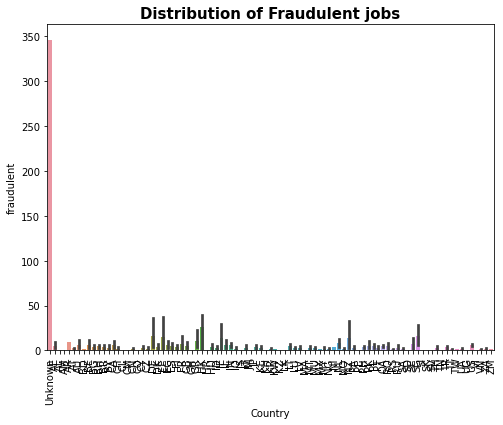

In [56]:
# sns.barplot(x = df.Country, y = df.fraudulent_jobs)
# plt.xticks(rotation = 90)
# plt.show()

plt.figure(figsize=(8,6))
chart = sns.barplot(x=df.Country, y=df.fraudulent)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.title('Distribution of Fraudulent jobs',size=15, weight='bold')
plt.show()

In [ ]:
sql_statement_eda = """
select
CASE e.EmploymentType
        WHEN '' THEN 'Unknown'
        ELSE e.EmploymentType
    END EmploymentType,
    count(p.job_id) as fraudulent_jobs from EmploymentTypes e
inner join Posting p
on e.EmploymentTypeId = p.EmploymentTypeId
where p.fraudulent = 1
group by EmploymentType
"""
df = pd.read_sql_query(sql_statement_eda,conn1)
sns.barplot(x = df.EmploymentType, y = df.fraudulent_jobs)
plt.xticks(rotation = 90)
plt.show()

In [ ]:
plt.figure(figsize=(8,6))
cat_num = df.neighbourhood_group.value_counts()
print("graph for %s: total = %d" % ('neighbourhood_group', len(cat_num)))
chart = sns.barplot(x=cat_num.index, y=cat_num)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.title('Neighbourhood group',size=15, weight='bold')
plt.savefig('neighbourhood_group.png')
plt.show()

In [ ]:
df.neighbourhood_group.value_counts()